<a href="https://colab.research.google.com/github/swechhasingh/nlp-from-scratch/blob/main/transformer_LM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Char-level Language Model - Part 3

* Char-Transformer: A char-level transformer based language model trained on a toy dataset of Shakespeare's work to predict Shakespeasre like language.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [16]:
# The Tiny Shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2023-02-07 19:10:50--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.1’

input.txt.1         100%[===================>]   1.06M  --.-KB/s    in 0.007s  

2023-02-07 19:10:50 (151 MB/s) - ‘input.txt.1’ saved [1115394/1115394]



In [17]:
with open("input.txt", 'r', encoding='utf-8') as file:
    input_text = file.read()

In [18]:
print(f"Length of input text: {len(input_text)}")
print(input_text[:1000])

Length of input text: 1115394
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread

In [19]:
# create a character vocabulary
char_vocab = sorted(set(input_text))
vocab_size = len(char_vocab)
print(f"{vocab_size=} and characters in vocab: {''.join(char_vocab)}")
# In our vocab, first character is new line character '\n' and second character is space ' '.

vocab_size=65 and characters in vocab: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


#### Tokenization: Text to integer mapping

We will be using character to integer tokenizer.

Other possible tokenizsers, Sub-word tokenizers:
* [OpenAI's tiktoken](https://github.com/openai/tiktoken)
* [Google's SentencePiece](https://pypi.org/project/sentencepiece/)

In [20]:
# character to index mapping
chartoi = {}
# index to character mapping
itochar = {}
for i, c in enumerate(char_vocab):
    chartoi[c] = i
    itochar[i] = c
print(f"{chartoi=}")
print(f"{itochar=}")

encode = lambda char_seq: [chartoi[char] for char in char_seq]
decode = lambda idx_seq: "".join([itochar[idx] for idx in idx_seq])

chartoi={'\n': 0, ' ': 1, '!': 2, '$': 3, '&': 4, "'": 5, ',': 6, '-': 7, '.': 8, '3': 9, ':': 10, ';': 11, '?': 12, 'A': 13, 'B': 14, 'C': 15, 'D': 16, 'E': 17, 'F': 18, 'G': 19, 'H': 20, 'I': 21, 'J': 22, 'K': 23, 'L': 24, 'M': 25, 'N': 26, 'O': 27, 'P': 28, 'Q': 29, 'R': 30, 'S': 31, 'T': 32, 'U': 33, 'V': 34, 'W': 35, 'X': 36, 'Y': 37, 'Z': 38, 'a': 39, 'b': 40, 'c': 41, 'd': 42, 'e': 43, 'f': 44, 'g': 45, 'h': 46, 'i': 47, 'j': 48, 'k': 49, 'l': 50, 'm': 51, 'n': 52, 'o': 53, 'p': 54, 'q': 55, 'r': 56, 's': 57, 't': 58, 'u': 59, 'v': 60, 'w': 61, 'x': 62, 'y': 63, 'z': 64}
itochar={0: '\n', 1: ' ', 2: '!', 3: '$', 4: '&', 5: "'", 6: ',', 7: '-', 8: '.', 9: '3', 10: ':', 11: ';', 12: '?', 13: 'A', 14: 'B', 15: 'C', 16: 'D', 17: 'E', 18: 'F', 19: 'G', 20: 'H', 21: 'I', 22: 'J', 23: 'K', 24: 'L', 25: 'M', 26: 'N', 27: 'O', 28: 'P', 29: 'Q', 30: 'R', 31: 'S', 32: 'T', 33: 'U', 34: 'V', 35: 'W', 36: 'X', 37: 'Y', 38: 'Z', 39: 'a', 40: 'b', 41: 'c', 42: 'd', 43: 'e', 44: 'f', 45: 'g', 4

In [21]:
print(f"Encode: {input_text[:30]}")
print(f"Encoded sentence:{encode(input_text[:30])}\nDecoded sentence:{decode(encode(input_text[:30]))}")


Encode: First Citizen:
Before we proce
Encoded sentence:[18, 47, 56, 57, 58, 1, 15, 47, 58, 47, 64, 43, 52, 10, 0, 14, 43, 44, 53, 56, 43, 1, 61, 43, 1, 54, 56, 53, 41, 43]
Decoded sentence:First Citizen:
Before we proce


In [22]:
# encode entire text
data = torch.tensor(encode(input_text), dtype=torch.long)
data[:20]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56])

Train/Val split

In [23]:
n_train = int(0.9*len(data))
train_data = data[:n_train]
val_data = data[n_train:]
print(f"n_train:{n_train} and n_val: {val_data.shape[0]}")

n_train:1003854 and n_val: 111540


Create batch

In [52]:
# context length/block size/chunk size
block_size = 8
def build_batch(split, batch_size=4, block_size=8):
    data = train_data if split == "train" else val_data
    start_idxs = torch.randint(0, len(data)-block_size, size=(batch_size,))
    #input 
    X = torch.stack([data[idx:idx+block_size] for idx in start_idxs])
    #target (input shift right by one)
    Y = torch.stack([data[idx+1:idx+block_size+1] for idx in start_idxs])
    X, Y = X.to(device), Y.to(device)
    return X, Y

Each input sequence of length `block_size` has `block_size` number of inputs packed into it.

In [26]:
X, Y = build_batch(split="train")
for b in range(1): # batch dimension
    print(f"Input: {X[b]} and target: {Y[b]}")
    for t in range(block_size): # time dimension
        context = X[b, :t+1]
        target = Y[b,t]
        print(f"when input is {context.tolist()} the target: {target}")
print(f"Input to the transformer:\n{X}")

Input: tensor([63,  1, 46, 47, 57,  1, 46, 53]) and target: tensor([ 1, 46, 47, 57,  1, 46, 53, 56])
when input is [63] the target: 1
when input is [63, 1] the target: 46
when input is [63, 1, 46] the target: 47
when input is [63, 1, 46, 47] the target: 57
when input is [63, 1, 46, 47, 57] the target: 1
when input is [63, 1, 46, 47, 57, 1] the target: 46
when input is [63, 1, 46, 47, 57, 1, 46] the target: 53
when input is [63, 1, 46, 47, 57, 1, 46, 53] the target: 56
Input to the transformer:
tensor([[63,  1, 46, 47, 57,  1, 46, 53],
        [47, 52, 45,  6,  1, 39, 52,  1],
        [26, 13, 10,  0, 20, 59, 57, 40],
        [47, 64, 43,  1, 39, 40, 53, 60]])


In [ ]:
emb_dim = 32

#### Baseline
Bigram neural network model using pytorch embedding layer

In [90]:
class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size) -> None:
        super().__init__()
        self.embedding_layer = nn.Embedding(vocab_size, vocab_size) # input: (B,T) output: (B, T, vocab_size)
        # self.output_layer = nn.Linear(emb_dim, vocab_size) # input: (B, T, emb_dim) output: (B, T, vocab_size)

    def forward(self, idx, target=None):
        logits = self.embedding_layer(idx)
        if target is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            target = target.view(B*T)
            loss = F.cross_entropy(logits, target)
        return logits, loss

    def generate(self, idx, max_token):
        max_token = 100
        for i in range(max_token):
            logits, _ = self(idx[:,-block_size:]) # idx: (B,T) logits: (B, T, vocab_size)
            logits = logits[:,-1,:] # only last position token is required to generate next character
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            sample = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, sample), dim=1)
        return idx



Let's check if the model is implemented correctly by computing loss with the initial random weights before training.



In [91]:
bigram_model = BigramLanguageModel(vocab_size).to(device)
X, Y = build_batch(split="train", batch_size=4, block_size=8)
logits, loss = bigram_model(X, Y)
print(logits.shape)
print(loss) # should be approx -ln(1/vocab_size)
start_token = torch.zeros((1, 1), dtype=torch.long, device=device)
generated_token = bigram_model.generate(start_token, max_token=100)
print(decode(generated_token[0].tolist()))

torch.Size([32, 65])
tensor(4.7676, device='cuda:0', grad_fn=<NllLossBackward0>)


uBoKyLEmtgffDBs?tBN;M$?
WY,'Jm.
?'
RCr VK.'sxxTF
3kJymWJcSCJ Qw
TxXDqN&iPM !RqzGpDDzXUXUrIz!zXrbPbB


Train bigram model

In [2]:
lr = 1e-3
batch_size = 32
block_size = 8
n_iter = 5000

In [107]:
model = BigramLanguageModel(vocab_size).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr)

# print the number of parameters in the model = vocab_size * vocab_size
print(sum(p.numel() for p in model.parameters()), 'parameters')

4225 parameters


In [108]:
train_loss = []
val_loss = []

In [109]:
# training loop
for iter in range(n_iter):
    model.train()
    X, y = build_batch("train", batch_size, block_size)
    logits, loss = model(X, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss.append(loss.item())
    if iter % 100 == 0:
        model.eval()
        X, y = build_batch("val", batch_size, block_size)
        logits, loss = model(X, y)
        val_loss.append(loss.item())
        if iter % 1000 == 0:
            print(f"Iteration {iter}: val_loss={loss}")
            start_token = torch.zeros((1, 1), dtype=torch.long, device=device)
            generated_token = bigram_model.generate(start_token, max_token=100)
            print(f"Generated text:{decode(generated_token[0].tolist())}")
            print("----------------------------------------------")


Iteration 0: val_loss=4.737429618835449
Generated text:
u?DYu-FqEuAD3FLym!EttcUr?tb-qN&.swasHlnV:,$mdybgGCpNsnrUCswF;.oCPKEi!QmKeWBgVa$X3UlRmuGpb-xsv;:lElqz
----------------------------------------------
Iteration 1000: val_loss=3.7747020721435547
Generated text:
D,lnQG'Q
Kk-qMcnOWkLE$qNVxSGcAwHtUr&OUP?AhU$3YuhJBs?'xlY:P,xCOQBUzhsp;CQDJBuo;M:,nW&t?VP;3PQp;
lY Jf
----------------------------------------------
Iteration 2000: val_loss=3.218496322631836
Generated text:
fpdu
&s
'FUZFTMSwcG?yzvIrbjYXuKySefza
AfkJ3JUjgbKip'FtjLWBvy
Q?-Il3.VZnM:lv;GxgtduKEtYXD3p!!BHDHvFTw
----------------------------------------------
Iteration 3000: val_loss=2.898283004760742
Generated text:
YG$duKdw,JBuu Kspmnmno.!xl3Vvd3O;xEmgJHvxUlfi?qA,VG&Wj3
!G3waUlqhVPHOxnvKOUz;ZV;AgB-x?Ie3gY  AhMpUYJ
----------------------------------------------
Iteration 4000: val_loss=2.5715856552124023
Generated text:
RgiCzBHElLd?.fgjj'YJvhZhBZfUiTP3FDNMRLF!RI;.OhrWLz.Cg
&sw-IpDmuBcOVHlLBuJytcXQ's$rMLdBMnICH;ERnZthZZ
-------------

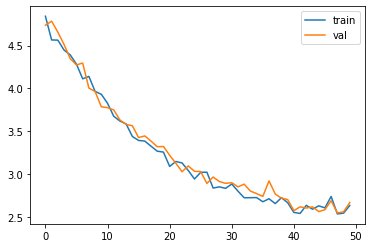

In [110]:
plt.plot(train_loss[::100], label="train")
plt.plot(val_loss, label="val")
plt.legend()

In [111]:
val_loss[-1], train_loss[-1]

(2.6663873195648193, 2.548964023590088)

In [113]:
start_token = torch.zeros((1, 1), dtype=torch.long, device=device)
generated_token = bigram_model.generate(start_token, max_token=500)
print(f"Generated text:{decode(generated_token[0].tolist())}")

Generated text:
SRnQrh$?z.ig!GkIs
!kICPDYeHlNxCa!WLIC&f
C&Ietxt,$yDuyETwr JfCgs
mu?vdBZZtUMrfpozBuxPcZ kI?fl'Go;MN&P


#### Types of Attention:
* Self-attention
* **Causal self-attention**: we will be implementing this
* Cross-attention

##### Causal self-attention from Transformer architecture: Masked Scaled Dot-Product Attention
$CausalAttention(Q,K,V)=MaskedSoftmax(\frac{QK^T}{\sqrt{d_k}})V$

In [33]:
# Single head self-attention
emb_dim = 32
head_dim = 16
# x is input to each head
x = torch.rand((batch_size, block_size, emb_dim))

# for each head, apply different learned linear transform on x to get query, key and value 
query = nn.Linear(emb_dim, head_dim, bias=False)
key = nn.Linear(emb_dim, head_dim, bias=False)
value = nn.Linear(emb_dim, head_dim, bias=False)

Q = query(x) # (batch_size, block_size, head_dim)
K = key(x) # (batch_size, block_size, head_dim)
V = value(x) # (batch_size, block_size, head_dim)

Q.shape, V.shape, K.shape

# MatMul
weight_matrix = Q @ K.transpose(1,2)
# Scale
weight_matrix = weight_matrix * head_dim **(-0.5)
# Mask for causal self-attention
mask = torch.tril(torch.ones(block_size, block_size))
weight_matrix = weight_matrix.masked_fill(mask == 0, float("-inf"))
# softmax
weight_matrix = F.softmax(weight_matrix, dim=-1)
weight_matrix.shape, V.shape
# MatMul (weighted sum)
out = weight_matrix @ V

out.shape

torch.Size([32, 8, 16])